In [1]:
import sys
!{sys.executable} -m pip install --user -r requirements.txt

In [14]:
import pandas as pd
from functools import reduce
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
from IPython.display import display, HTML
import warnings
warnings.filterwarnings("ignore")

## Functions used

In [15]:
def make_barplot(data, feature):
    """
    Function for visualising the difference between categorical features for infected and normal hosts
    :param data: the dataframe containing the data
    :return:creates the wanted plot creates the wanted plot
    """
    plt.figure()
    feature_counts = (data.groupby(['is_infected'])[feature].value_counts(normalize=True).rename('percentage').mul(100)
                         .reset_index().sort_values(feature))
    ax = sns.barplot(x=feature, y='percentage', data=feature_counts, hue='is_infected',
                     palette={0: mcolors.TABLEAU_COLORS['tab:blue'], 1: mcolors.TABLEAU_COLORS['tab:red']})
    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles, ['Normal Hosts', 'Infected host'], loc='upper right')
    plt.xlabel("%s type" % feature)
    plt.ylabel("Percentage of occurrences")
    plt.grid()
    plt.show()
#     plt.savefig('plots/barplot_%s.png' % feature)

In [16]:
def make_bar_graphs(x, y, feature):
    """
    Function for visualising the difference between numerical features (mainly packtes and bytes) for infected and
    normal hosts
    :param x: the type of the hosts
    :param y: the numerical values
    :param feature: the type of the feature
    :return: creates the wanted plot
    """
    plt.figure()
    y_pos = np.arange(len(x))
    plt.bar(y_pos, y, align='center', alpha=0.5, color=[mcolors.TABLEAU_COLORS['tab:blue'],
                                                        mcolors.TABLEAU_COLORS['tab:red']])
    plt.xticks(y_pos, x)
    plt.xlabel('Type of host')
    plt.ylabel(feature)
    plt.title('Average number of %s sent' % feature)
    plt.show()
#     plt.savefig('plots/barplot_%s.png' % feature)

In [17]:
def netflow_encoding(flow, mappings):
    """
    The netflow encoding described in Pellegrino, Gaetano, et al. "Learning Behavioral Fingerprints From Netflows Using
    Timed Automata."
    :param flow: the flow to be given a code
    :param df: the dataframe with all flows
    :param mappings: dictionary with the features to be used for encoding and their cardinality
    :return: the code that represents the flow
    """
    code = 0
    space_size = reduce((lambda x, y: x * y), list(mappings.values()))
    for feature in mappings.keys():
        code += flow[feature+'_num']*space_size/mappings[feature]
        space_size = space_size/mappings[feature]
    return code

In [18]:
def find_percentile(val, percentiles):
    """
    Helper function returning the relative index of placement in the percentiles
    :param val: the value to be indexed
    :param percentiles: the percentile limits
    :return: the index of val in the percentiles
    """
    ind = len(percentiles)
    for i, p in enumerate(percentiles):
        if val <= p:
            ind = i
            break
    return ind

In [19]:
def remove_background(df):
    """
    Helper function removing background flows from a given dataframe
    :param df: the dataframe
    :return: the no-background dataframe
    """
    df = df[df['label'] != 'Background']
    return df

## Read the dataset for scenario 10

In [20]:
# # read the data in chunks due to their large size - uncomment the following lines if you want to read them again
# # and store them in a pickle
# dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f')
# data = pd.concat(remove_background(chunk) for chunk in pd.read_csv('scenario10/capture20110818.pcap.netflow.labeled_v2',
#                                                                    chunksize=100000, delimiter=',',
#                                                                    parse_dates=['date'], date_parser=dateparse))
# data.to_pickle('no_background_data.pkl')

# if the data without the background are there, load them
data = pd.read_pickle('no_background_data.pkl')

## Initial preprocessing of the data

In [21]:
# resetting indices for data
data = data.reset_index(drop=True)

# parse packets and bytes as integers instead of strings
data['packets'] = data['packets'].astype(int)
data['bytes'] = data['bytes'].astype(int)

# add the numerical representation of the categorical data
data['protocol_num'] = pd.Categorical(data['protocol'], categories=data['protocol'].unique()).codes
data['flags_num'] = pd.Categorical(data['flags'], categories=data['flags'].unique()).codes

## Pick one infected host and the normal ones

In [22]:
# pick one infected host and the normal ones
infected_ip = '147.32.84.165'
normal_ips = ['147.32.84.170', '147.32.84.134', '147.32.84.164', '147.32.87.36', '147.32.80.9', '147.32.87.11']

# currently using only source ips for infected and normal discrimination
infected = data[data['src_ip'] == infected_ip]
infected = infected.reset_index()

normal = data[data['src_ip'].isin(normal_ips)]
normal = normal.reset_index()

## Check statistics of the data for the infected and the normal hosts to decide on the features for discretization

---------------- Stats for infected host ----------------


,duration,protocol_num,flags_num,tos,packets,bytes,flows
count,19889.000000,19889.000000,19889.000000,19889.0,19889.000000,19889.000000,19889.0
mean,0.551279,1.941676,26.982050,0.0,15.838705,14104.124943,1.0
std,1.436274,0.309928,10.914621,0.0,102.152312,84291.197116,0.0
min,0.000000,0.000000,0.000000,0.0,1.000000,60.000000,1.0
25%,0.000000,2.000000,17.000000,0.0,1.000000,1066.000000,1.0
50%,0.000000,2.000000,33.000000,0.0,1.000000,1066.000000,1.0
75%,0.000000,2.000000,35.000000,0.0,1.000000,1066.000000,1.0
max,4.999000,2.000000,72.000000,0.0,1000.000000,787188.000000,1.0


---------------- Stats for normal hosts ----------------


,duration,protocol_num,flags_num,tos,packets,bytes,flows
count,39925.000000,39925.000000,39925.000000,39925.0,39925.000000,3.992500e+04,39925.0
mean,0.356154,0.280651,3.515692,0.0,11.064596,8.127969e+03,1.0
std,1.045342,0.487452,3.664362,0.0,119.777720,1.236821e+05,0.0
min,0.000000,0.000000,0.000000,0.0,1.000000,6.000000e+01,1.0
25%,0.000000,0.000000,1.000000,0.0,1.000000,6.600000e+01,1.0
50%,0.000000,0.000000,2.000000,0.0,1.000000,8.100000e+01,1.0
75%,0.037000,1.000000,5.000000,0.0,4.000000,3.330000e+02,1.0
max,4.999000,2.000000,31.000000,0.0,5206.000000,7.762895e+06,1.0


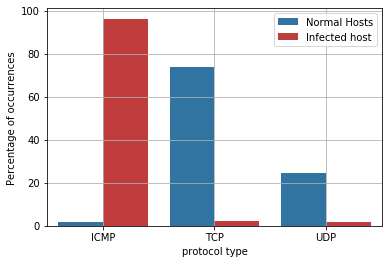

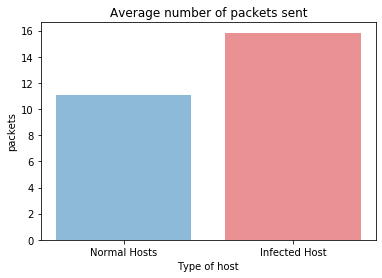

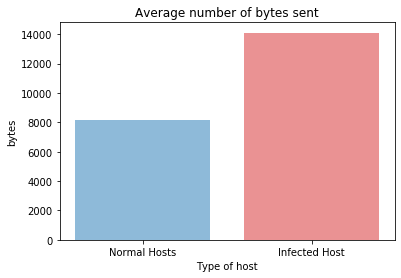

plots created


In [23]:
# separate the types of features in the dataset
continuous_features = ['duration', 'protocol_num', 'flags_num', 'tos', 'packets', 'bytes', 'flows']
categorical_features = ['protocol', 'flags']

# check statistics for the most discriminative features in the dataset
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print('---------------- Stats for infected host ----------------')
    display(HTML(infected[continuous_features].describe().to_html()))
    print('---------------- Stats for normal hosts ----------------')
    display(HTML(normal[continuous_features].describe().to_html()))

# preprocess the infected and normal data and plot possible feature candidates
plot_data = pd.concat([infected, normal], ignore_index=True)
for index, ip in enumerate(plot_data['src_ip']):
    val = 1 if ip == infected_ip else 0
    plot_data.set_value(index, 'is_infected', val)

make_barplot(plot_data, 'protocol')
make_bar_graphs(['Normal Hosts', 'Infected Host'], [normal["packets"].mean(), infected["packets"].mean()], 'packets')
make_bar_graphs(['Normal Hosts', 'Infected Host'], [normal["bytes"].mean(), infected["bytes"].mean()], 'bytes')
print('plots created')

## Select the wanted features and apply clustering in case they are numerical

Type two feature names for discretization separated by space
 (possible choices: duration, protocol, flags, tos, packets, bytes, flows): protocol bytes
----------------------- Finding optimal number of bins for bytes -----------------------


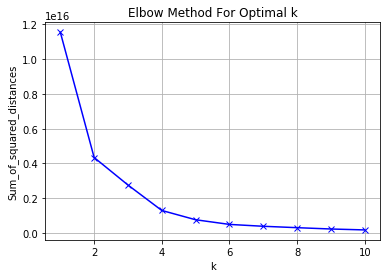

Enter your preferred number of clusters: 4


In [27]:
# and select 2 of them
selected_features = input('Type two feature names for discretization separated by space\n '
                          '(possible choices: duration, protocol, flags, tos, packets, bytes, flows): ').split()

for sel in selected_features:
    if sel in continuous_features:
        # apply the elbow method
        print('----------------------- Finding optimal number of bins for {} -----------------------'.format(sel))
        Sum_of_squared_distances = []
        for k in range(1, 11):
            km = KMeans(n_clusters=k)
            km = km.fit(data[sel].values.reshape(-1, 1))
            Sum_of_squared_distances.append(km.inertia_)

        plt.figure()
        plt.plot(range(1, 11), Sum_of_squared_distances, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum_of_squared_distances')
        plt.title('Elbow Method For Optimal k')
        plt.grid()
        plt.show()
#         plt.savefig('plots/elbow_discretization_%s.png' % sel, bbox_inches='tight')

        percentile_num = int(input('Enter your preferred number of clusters: '))

        # assign the cluster id to each value of the selected numerical feature in the way that it is described in
        # in Pellegrino, Gaetano, et al. "Learning Behavioral Fingerprints From Netflows Using Timed Automata."
        percentile_values = list(map(lambda p: np.percentile(data[sel], p), 100*np.arange(0, 1, 1 / percentile_num)[1:]))
        data[sel+'_num'] = data[sel].apply(find_percentile, args=(percentile_values,))

## Discretize the flows 

In [28]:
# reselect the data
infected = data[data['src_ip'] == infected_ip]
infected = infected.reset_index()
normal = data[data['src_ip'].isin(normal_ips)]
normal = normal.reset_index()

# discretize all flows
print('Discretizing all hosts...')
mappings = {}
for sel_feat in selected_features:
    mappings[sel_feat] = len(data[sel_feat + '_num'].unique())
data['encoded'] = data.apply(lambda x: netflow_encoding(x, mappings), axis=1)
data.to_pickle('all_discretized_%s.pkl' % '_'.join(selected_features))
print('Discretization completed')

Discretizing all hosts...
Discretization completed
